In [1]:
'''
Multi-Layer Perceptron
Cleared to run by Genesis 7/13/2020
Only takes in 3 minerals right now because it's messy code and super slow
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import trange
import seaborn as sn
from pprint import pprint
from __future__ import print_function
from IPython.display import clear_output
from google.colab import drive
drive.mount('/content/drive/')
np.random.seed(42)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
class Layer:
# Each layer will process input and output = layer.forward(input)
# Propagate gradients through itself grad_input = layer.backward(input, grad_output)
# Layers with learnable parameters will update them during layer.backward

  def __init__(self):
    # Initialize layer parameters (if any) and auxiliary stuff.
    pass
    
  def forward(self, input):
    # Takes input data of shape [batch, input_units], returns output data [batch, output_units]
    return input

  def backward(self, input, grad_output):
    # Performs a backpropagation step through the layer, with respect to the given input.
    # To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
    # d loss / d x  = (d loss / d layer) * (d layer / d x)
    # Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
    # If layer has parameters (e.g. dense layer), we update them here using d loss / d layer
    # The gradient of a dummy layer is precisely grad_output, but more explicitly:
    num_units = input.shape[1]
 
    d_layer_d_input = np.eye(num_units)
        
    return np.dot(grad_output, d_layer_d_input) # chain rule

In [3]:
class ReLU(Layer):
  def __init__(self):
    # ReLU layer applies elementwise rectified linear unit to all inputs
    pass
    
  def forward(self, input):
    # Apply elementwise ReLU to [batch, input_units] matrix
    relu_forward = np.maximum(0, input) # todo

    return relu_forward
    
  def backward(self, input, grad_output):
    # Compute gradient of loss w.r.t. ReLU input
    relu_grad = input > 0

    return grad_output * relu_grad 

In [4]:
class Dense(Layer):
  def __init__(self, input_units, output_units, learning_rate = 0.01): # LEARNING RATE
    # Dense layer performs a learned affine transformation:
    # f(x) = <W * x> + b
        
    self.learning_rate = learning_rate
    self.weights = np.random.normal(loc = 0.0, scale = np.sqrt(2 / (input_units + output_units)), size = (input_units, output_units))
    self.biases = np.zeros(output_units)
        
  def forward(self,input):
    # Perform an affine transformation:
    # f(x) = <W * x> + b
        
    # input shape: [batch, input_units]
    # output shape: [batch, output units]
        
    return np.dot(input, self.weights) + self.biases
    
  def backward(self, input, grad_output):
    # Compute d f / d x = d f / d dense * d dense / d x
    # where d dense/ d x = weights transposed
    grad_input = np.dot(grad_output, self.weights.T)
        
    # Compute gradient w.r.t. weights and biases
    grad_weights = np.dot(input.T, grad_output)
    grad_biases = grad_output.mean(axis = 0) * input.shape[0]
        
    assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
    # stochastic gradient descent 
    self.weights = self.weights - self.learning_rate * grad_weights
    self.biases = self.biases - self.learning_rate * grad_biases
        
    return grad_input

In [5]:
def softmax_crossentropy_with_logits(logits, reference_answers):
  # Compute crossentropy from logits[batch, n_classes] and ids of correct answers
  logits_for_answers = logits[np.arange(len(logits)), reference_answers]
    
  xentropy = np.log(np.sum(np.exp(logits), axis = -1)) - logits_for_answers
    
  return xentropy

def grad_softmax_crossentropy_with_logits(logits, reference_answers):
  # Compute crossentropy gradient from logits[batch, n_classes] and ids of correct answers
  ones_for_answers = np.zeros_like(logits)
  ones_for_answers[np.arange(len(logits)), reference_answers] = 1
    
  softmax = np.exp(logits) / np.exp(logits).sum(axis = -1, keepdims = True)
    
  return (softmax - ones_for_answers) / logits.shape[0]

In [6]:
def forward(network, X):
  # Compute activations of all network layers by applying them sequentially.
  # Return a list of activations for each layer. 
    
  activations = []
  input = X

  # Looping through each layer
  for l in network:
    activations.append(l.forward(input))
    # Updating input to last layer output
    input = activations[-1]
    
  assert len(activations) == len(network)
  return activations

def predict(network, X):
  # Compute network predictions. Returning indices of largest Logit probability

  logits = forward(network, X)[-1]
  return logits.argmax(axis = -1)

def train(network, X, y):
  # Train network on a given batch of X and y.
  # First run forward to get all layer activations.
  # Then run layer backward going from last to first layer.
  # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
  # Get the layer activations
  layer_activations = forward(network, X)
  layer_inputs = [X] + layer_activations # layer_input[i] is an input for network[i]
  logits = layer_activations[-1]
    
  # Compute the loss and the initial gradient
  loss = softmax_crossentropy_with_logits(logits, y)
  loss_grad = grad_softmax_crossentropy_with_logits(logits, y)
    
  # Propagate gradients through the network
  # Reverse propogation as this is backprop
  for layer_index in range(len(network))[::-1]:
    layer = network[layer_index]
        
    loss_grad = layer.backward(layer_inputs[layer_index], loss_grad) # grad w.r.t. input, also weight updates
        
  return np.mean(loss)

In [7]:
def iterate_minibatches(inputs, targets, batchsize, shuffle = False):
  assert len(inputs) == len(targets)
  if shuffle:
    indices = np.random.permutation(len(inputs))
  for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
    if shuffle:
      excerpt = indices[start_idx : start_idx + batchsize]
    else:
      excerpt = slice(start_idx, start_idx + batchsize)
    yield inputs[excerpt], targets[excerpt]

In [8]:
def interpolate_data(data, xnew):
  arr = np.empty((0, 1000))
  pprint(arr)
  x = data.values[0]
  for i in range(len(data) - 1):
    y = data.values[i + 1]
    f = interp1d(x, y)
    ynew = f(xnew)
    arr = np.append(arr, [ynew], axis = 0)
  return arr

def load_data():
  rock_df = pd.read_csv(r'/content/drive/My Drive/ML Spectroscopy/Data/Raw Data/MLP Spectra in CSV Format/granite0dust_test_015s_5184.csv', header = None)
  albite_df = pd.read_csv(r'/content/drive/My Drive/ML Spectroscopy/Data/Raw Data/MLP Spectra in CSV Format/albite_train_015s_5250.csv', header = None)
  microcline_df = pd.read_csv(r'/content/drive/My Drive/ML Spectroscopy/Data/Raw Data/MLP Spectra in CSV Format/mc_train_015s_5600.csv', header = None)
  quartz_df = pd.read_csv(r'/content/drive/My Drive/ML Spectroscopy/Data/Raw Data/MLP Spectra in CSV Format/qtz_train_003s_4760.csv', header = None)

  albite_df.drop(albite_df.columns[[0, 1]], axis = 1, inplace = True)
  microcline_df.drop(microcline_df.columns[[0, 1]], axis = 1, inplace = True)
  quartz_df.drop(quartz_df.columns[[0, 1]], axis = 1, inplace = True)

  xnew = np.linspace(101, 1100, num = 1000, endpoint = True)

  rock = interpolate_data(rock_df, xnew)
  albite = interpolate_data(albite_df, xnew)
  microcline = interpolate_data(microcline_df, xnew)
  quartz = interpolate_data(quartz_df, xnew)
  print(rock.shape)
  print(albite.shape)
  print(microcline.shape)
  print(quartz.shape)
  X_data = np.concatenate((albite, microcline, quartz))
  y_data = np.concatenate((np.full(5250, 0), np.full(5600, 1), np.full(4760, 2)))

  s = np.arange(X_data.shape[0])
  np.random.shuffle(s)
  X_data = X_data[s]
  y_data = y_data[s]

  X_test = rock
  y_test = np.array([])

  X_min = min(np.amin(X_data), np.amin(X_test))
  X_max = max(np.amax(X_data), np.amax(X_test))

  X_data = (X_data - X_min) / (X_max - X_min)
  X_test = (X_test - X_min) / (X_max - X_min)

  dataLen = len(X_data)

  X_train = X_data[:int(dataLen * 0.66)]
  y_train = y_data[:int(dataLen * 0.66)]

  X_val = X_data[int(dataLen * 0.66):]
  y_val = y_data[int(dataLen * 0.66):]

  print('training dataset size: ' + str(len(X_train)))
  print('testing dataset size: ' + str(len(X_test)))
  print('validation dataset size: ' + str(len(X_val)))

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_data()
#print(X_train)
#print(y_train)
#print(X_val)
#print(y_val)
#print(X_test)
#print(y_test)

array([], shape=(0, 1000), dtype=float64)
array([], shape=(0, 1000), dtype=float64)
array([], shape=(0, 1000), dtype=float64)
array([], shape=(0, 1000), dtype=float64)
(5184, 1000)
(5250, 1000)
(5600, 1000)
(4760, 1000)
training dataset size: 10302
testing dataset size: 5184
validation dataset size: 5308


In [9]:
# Network defined as a list of layers applied on top of previous layers
network = [] # NETWORK DIMENSIONS
network.append(Dense(X_train.shape[1], 1000))
network.append(ReLU())
network.append(Dense(1000, 100))
network.append(ReLU())
network.append(Dense(100, 10))

In [10]:
train_accuracy_log = []
val_accuracy_log = []
train_loss_log = []
val_loss_log = []

Epoch 25
Current Training Accuracy: 0.9997087944088526
Current Validation Accuracy: 0.9994348153730218
Current Training Loss: 0.0048230436541124855
Current Validation Loss: 0.005105001890266928
Training Accuracy: [0.5526111434672879, 0.8736167734420501, 0.8870122306348281, 0.8865268879829159, 0.8969132207338381, 0.9099204038050864, 0.9344787419918462, 0.9370995923121724, 0.9677732479130265, 0.9901960784313726, 0.9952436420112599, 0.9979615608619685, 0.9988351776354106, 0.9993205202873229, 0.9995146573480878, 0.9996117258784702, 0.9997087944088526, 0.999126383226558, 0.9997087944088526, 0.9997087944088526, 0.9998058629392351, 0.9998058629392351, 0.9997087944088526, 0.9998058629392351, 0.9997087944088526]
Validation Accuracy: [0.5454031650339111, 0.8643556895252449, 0.8756593820648079, 0.8754709871891485, 0.8845139412207988, 0.8978899773926149, 0.9272795779954786, 0.9302938960060286, 0.9670308967596082, 0.9902034664657121, 0.9958553127354935, 0.9981160512434062, 0.9986812358703844, 0.999

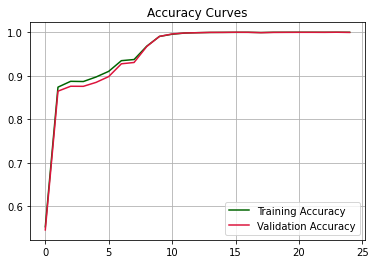

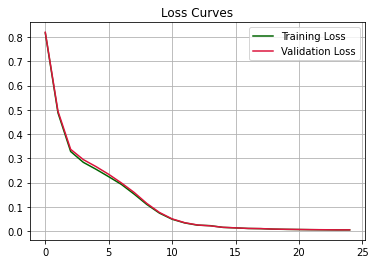

In [11]:
for epoch in range(25): # EPOCHS
  for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize = 10, shuffle = True): # BATCH SIZE
    train(network, x_batch, y_batch)
  
  train_accuracy_log.append(np.mean(predict(network, X_train) == y_train))
  val_accuracy_log.append(np.mean(predict(network, X_val) == y_val))
  train_loss_log.append(train(network, X_train, y_train))
  val_loss_log.append(train(network, X_val, y_val))

  clear_output()
  
  print("Epoch", epoch + 1)

  print("Current Training Accuracy:", train_accuracy_log[-1])
  print("Current Validation Accuracy:", val_accuracy_log[-1])
  print("Current Training Loss:", train_loss_log[-1])
  print("Current Validation Loss:", val_loss_log[-1])

  print("Training Accuracy:", train_accuracy_log)
  print("Validation Accuracy:", val_accuracy_log)
  print("Training Loss:", train_loss_log)
  print("Validation Loss:", val_loss_log)

  plt.title('Accuracy Curves')
  plt.plot(train_accuracy_log, label = 'Training Accuracy', color = 'darkgreen')
  plt.plot(val_accuracy_log, label = 'Validation Accuracy', color = 'crimson')
  plt.legend(loc = 'best')
  plt.grid()
  plt.show()

  plt.title('Loss Curves')
  plt.plot(train_loss_log, label = 'Training Loss', color = 'darkgreen')
  plt.plot(val_loss_log, label = 'Validation Loss', color = 'crimson')
  plt.legend(loc = 'best')
  plt.grid()
  plt.show()

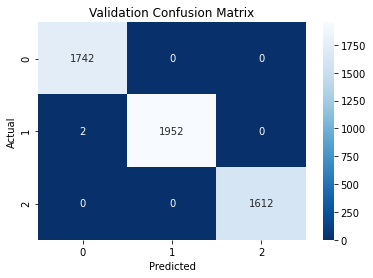

In [12]:
def plot_confusion_matrix(actual, predicted, matrix_title):
  data = {"y_Actual": actual, "y_Predicted": predicted}
  df = pd.DataFrame(data, columns=['y_Actual', 'y_Predicted'])
  confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
  sn.heatmap(confusion_matrix, annot = True, fmt='g', cmap=plt.cm.Blues_r)
  plt.title(matrix_title)
  plt.show()
np.set_printoptions(threshold=np.inf)
#print(y_val)
#print(predict(network, X_val))
plot_confusion_matrix(y_val, predict(network, X_val), "Validation Confusion Matrix")

In [13]:
#report metrics: precision, recall, f1-score, support for test set
from sklearn.metrics import classification_report
target_names = ['Albite', 'Microcline', 'Quartz']
print(classification_report(y_val,predict(network, X_val),target_names=target_names))


              precision    recall  f1-score   support

      Albite       1.00      1.00      1.00      1742
  Microcline       1.00      1.00      1.00      1954
      Quartz       1.00      1.00      1.00      1612

    accuracy                           1.00      5308
   macro avg       1.00      1.00      1.00      5308
weighted avg       1.00      1.00      1.00      5308



# Autoplotter - to label test sets quickly: plots spectrum, asks user to manually label, plots next row



In [14]:
'''
def autolabel_test_data(X_test)
  y_test = np.array()
  for spectra in X_test:
    fig, axs = plt.subplots(2, 2)
    fig.tight_layout(pad = 0.75)

    axs[0, 0].plot(albite[0])
    axs[0, 0].set_title("albite (0)")
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticks([])

    axs[0, 1].plot(microcline[0])
    axs[0, 1].set_title("microcline (1)")
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])

    axs[1, 0].plot(quartz[0])
    axs[1, 0].set_title("quartz (2)")
    axs[1, 0].set_xticks([])
    axs[1, 0].set_yticks([])

    axs[1, 1].plot(spectra)
    axs[1, 1].set_title("unknown")
    axs[1, 1].set_xticks([])
    axs[1, 1].set_yticks([])

    plt.show()
    print("\n" + "Which graph most closely matches the unknown graph")
    graph = int(input())
    y_rock = np.append(y_rock, graph)

    clear_output()
'''

'\ndef autolabel_test_data(X_test)\n  y_test = np.array()\n  for spectra in X_test:\n    fig, axs = plt.subplots(2, 2)\n    fig.tight_layout(pad = 0.75)\n\n    axs[0, 0].plot(albite[0])\n    axs[0, 0].set_title("albite (0)")\n    axs[0, 0].set_xticks([])\n    axs[0, 0].set_yticks([])\n\n    axs[0, 1].plot(microcline[0])\n    axs[0, 1].set_title("microcline (1)")\n    axs[0, 1].set_xticks([])\n    axs[0, 1].set_yticks([])\n\n    axs[1, 0].plot(quartz[0])\n    axs[1, 0].set_title("quartz (2)")\n    axs[1, 0].set_xticks([])\n    axs[1, 0].set_yticks([])\n\n    axs[1, 1].plot(spectra)\n    axs[1, 1].set_title("unknown")\n    axs[1, 1].set_xticks([])\n    axs[1, 1].set_yticks([])\n\n    plt.show()\n    print("\n" + "Which graph most closely matches the unknown graph")\n    graph = int(input())\n    y_rock = np.append(y_rock, graph)\n\n    clear_output()\n'